## Importando bibliotecas e base

In [90]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from scipy.signal import periodogram, detrend

from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
import shap 

from typing import Optional,Dict,Tuple
from pathlib import Path

from mlforecast.lag_transforms import ExpandingMean, RollingMean, RollingStd
from mlforecast.target_transforms import Differences, LocalStandardScaler

from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mape, mae, coverage, mase

from sklearn.linear_model import LinearRegression
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean, RollingStd
from mlforecast.target_transforms import Differences, AutoDifferences, LocalBoxCox, GlobalSklearnTransformer
from mlforecast.utils import PredictionIntervals
from utilsforecast.plotting import plot_series
import matplotlib.dates as mdates

from bcb import sgs
import os

from sklearn.preprocessing import FunctionTransformer
sk_log1p = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

# plots setup
# https://medium.com/@tttgm/styling-charts-in-seaborn-92136331a541
plt.rcParams.update(**{'figure.dpi': 150})
# color palette can be passed as a list of hex codes
custom_colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
# set overall plot style, font size scaling factor, and color palette
sns.set(style="whitegrid", font_scale=1, palette=custom_colors)
warnings.filterwarnings("ignore", "use_inf_as_na") # issue with seaborn

In [91]:
df = sgs.get({'IPCA': 433}, start='2015-01-01', end='2025-05-01')
df = df.reset_index()

In [92]:
df.head()

,Date,IPCA
0,2015-01-01,1.24
1,2015-02-01,1.22
2,2015-03-01,1.32
3,2015-04-01,0.71
4,2015-05-01,0.74


In [93]:
df['ds'] = df['Date']
df = df[['ds', 'IPCA']]

df['unique_id'] = 1

df.head()

,ds,IPCA,unique_id
0,2015-01-01,1.24,1
1,2015-02-01,1.22,1
2,2015-03-01,1.32,1
3,2015-04-01,0.71,1
4,2015-05-01,0.74,1


In [94]:
# Preprocessing to Nixtla format
df['y'] = df.IPCA
df = df[['unique_id', 'ds', 'y']]
df.head()

,unique_id,ds,y
0,1,2015-01-01,1.24
1,1,2015-02-01,1.22
2,1,2015-03-01,1.32
3,1,2015-04-01,0.71
4,1,2015-05-01,0.74


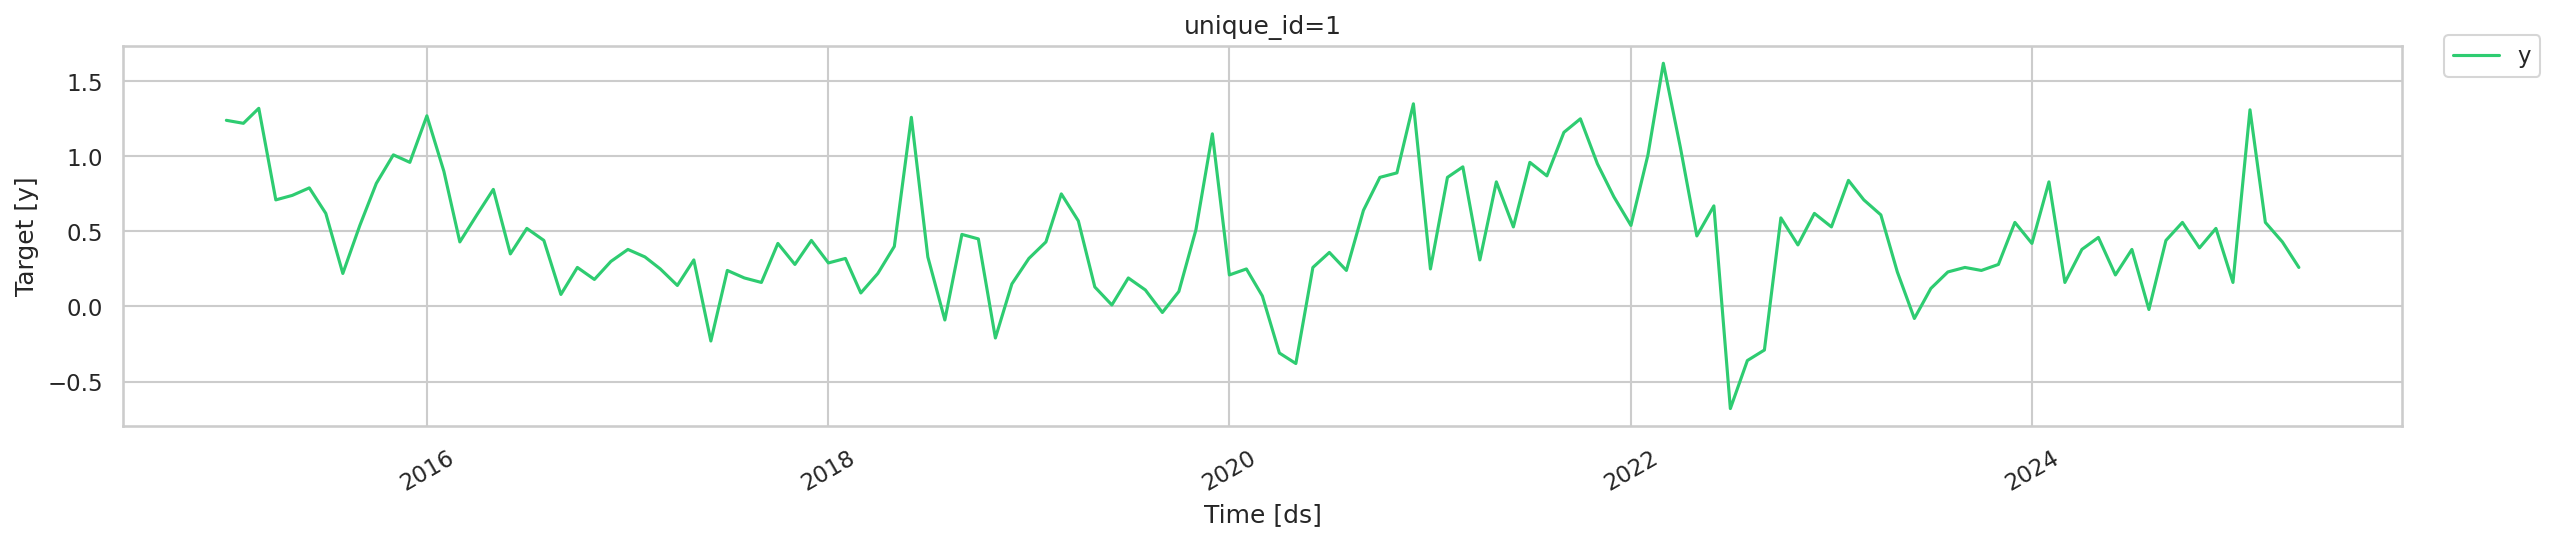

In [95]:
# Plotting the series
fig = plot_series(df)
fig

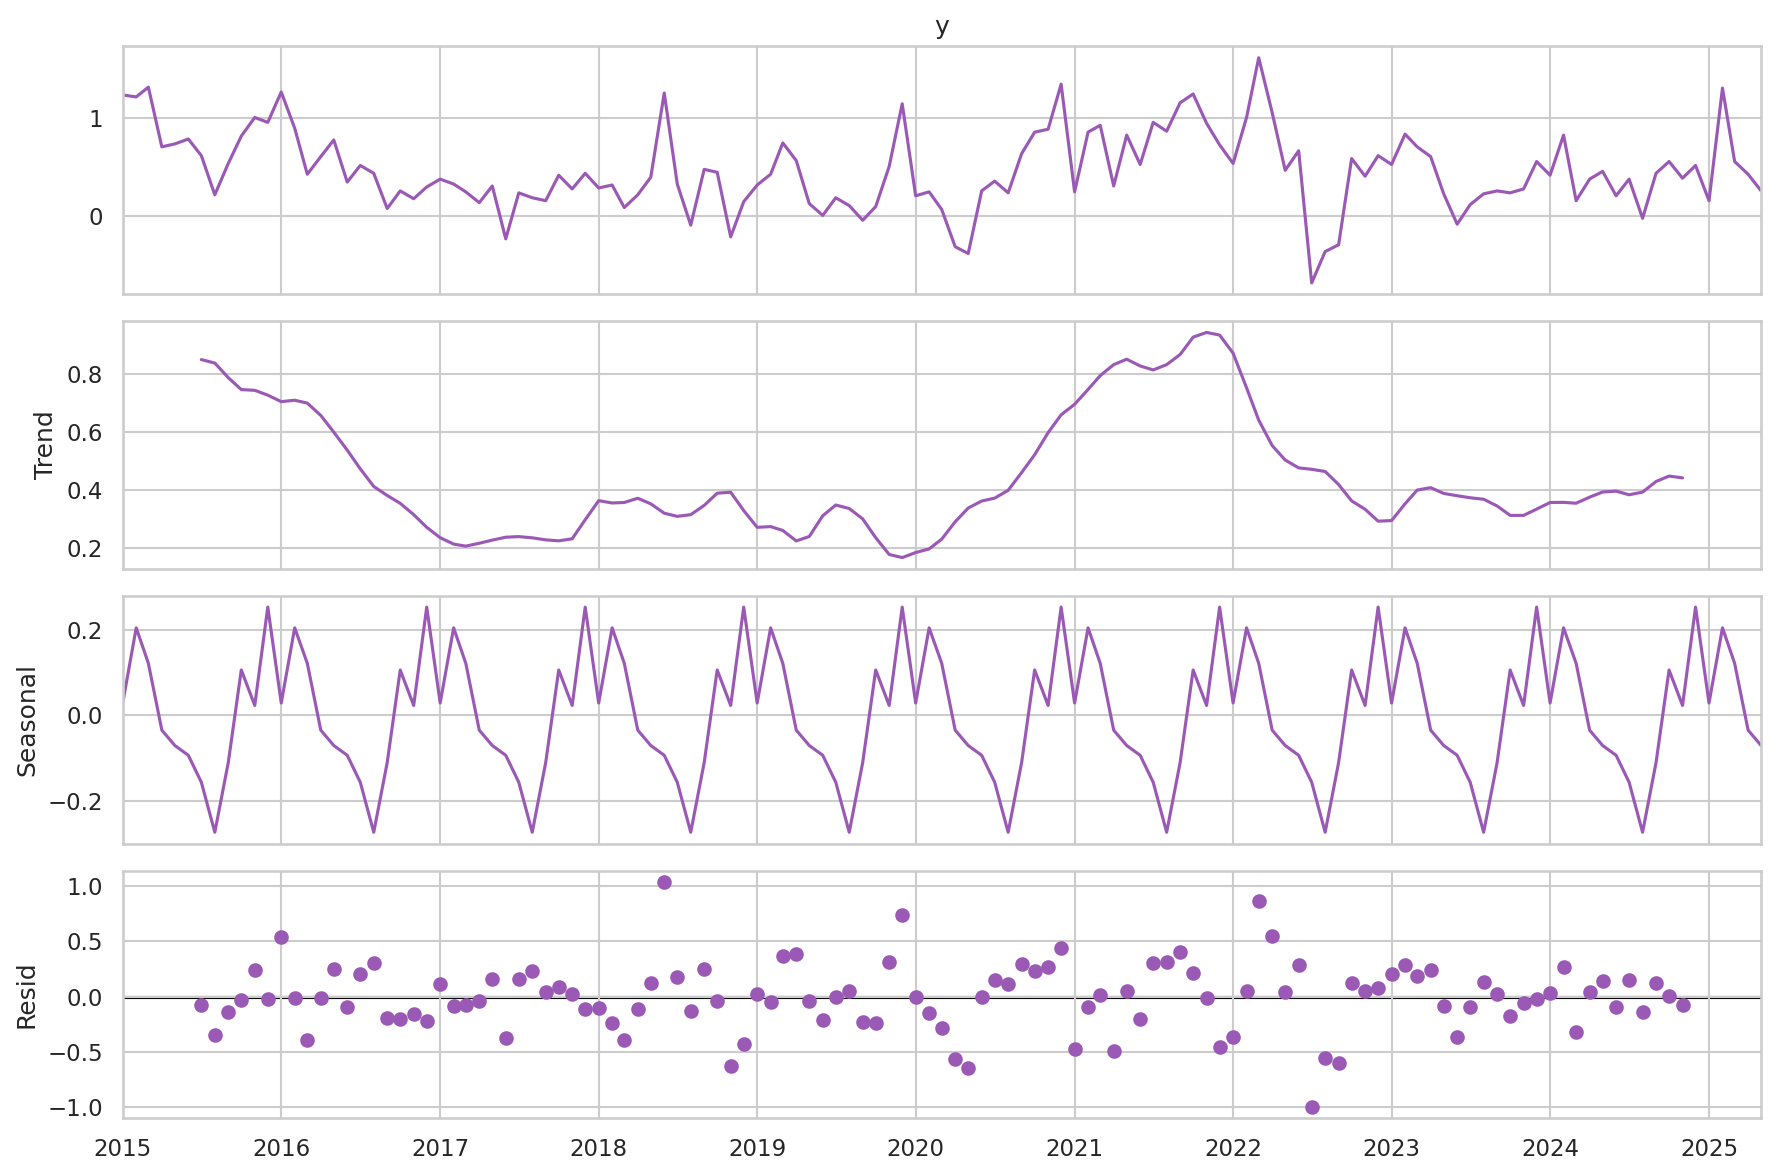

In [96]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(
    df.set_index('ds')['y'],  # usar toda a série ou um período mais longo
    model='additive',         # modelo aditivo (poderia ser 'multiplicative' para IPCA)
    period=12                 # sazonalidade anual para dados mensais
)

# Plotando os resultados
fig = result.plot()
fig.set_size_inches(12, 8)
plt.tight_layout()  # evita sobreposição de labels
plt.show()

In [97]:
from statsmodels.tsa.stattools import adfuller
serie = df[df['unique_id'] == 1].sort_values('ds')['y']

# Aplicar o teste ADF
resultado = adfuller(serie)

# Exibir os resultados
print('Estatística ADF:', resultado[0])
print('Valor-p:', resultado[1])
print('Nº de lags usados:', resultado[2])
print('Nº de observações:', resultado[3])
print('Valores críticos:')
for chave, valor in resultado[4].items():
    print(f'   {chave}: {valor}')


Estatística ADF: -6.254802952952393
Valor-p: 4.3652470020009853e-08
Nº de lags usados: 0
Nº de observações: 124
Valores críticos:
   1%: -3.484219653271961
   5%: -2.885145235641637
   10%: -2.579359138917794


#### Train/Test splint

In [98]:
# ## Train-test split
# We will use the last 12 months as the test set.

df_train = df[df.ds < '2024-06-01']
df_test = df[df.ds >= '2024-06-01']

In [99]:
models  = [
    CatBoostRegressor(n_estimators=200, random_state=42, verbose=False),
]
fcst = MLForecast(
    models=models,
    freq='MS',  # our serie has a monthly frequency
    lags=[12, 6, 3, 1],
    
    lag_transforms={
        1: [
            ExpandingMean(),
            RollingMean(window_size=3),
            RollingMean(window_size=6),
            RollingMean(window_size=12),
            RollingStd(window_size=3),
            RollingStd(window_size=6),
            RollingStd(window_size=12),
        ],
        3: [
            ExpandingMean(),
        ],
    },
    date_features=['month', 'quarter','year'], 
)



In [100]:
# Fit the forecast model
df_train_prep = fcst.preprocess(df_train)
df_train_prep.head()

,unique_id,ds,y,lag12,lag6,lag3,lag1,expanding_mean_lag1,rolling_mean_lag1_window_size3,rolling_mean_lag1_window_size6,rolling_mean_lag1_window_size12,rolling_std_lag1_window_size3,rolling_std_lag1_window_size6,rolling_std_lag1_window_size12,expanding_mean_lag3,month,quarter,year
12,1,2016-01-01,1.27,1.24,0.62,0.82,0.96,0.849167,0.930000,0.695000,0.849167,0.098489,0.296766,0.320467,0.822000,1,1,2016
13,1,2016-02-01,0.90,1.22,0.22,1.01,1.27,0.881538,1.080000,0.803333,0.851667,0.166433,0.372809,0.323892,0.839091,2,1,2016
14,1,2016-03-01,0.43,1.32,0.54,0.96,0.90,0.882857,1.043333,0.916667,0.825000,0.198578,0.239555,0.303330,0.849167,3,1,2016
15,1,2016-04-01,0.61,0.71,0.82,1.27,0.43,0.852667,0.866667,0.898333,0.750833,0.420991,0.275639,0.279137,0.881538,4,2,2016
16,1,2016-05-01,0.78,0.74,1.01,0.90,0.61,0.837500,0.646667,0.863333,0.742500,0.237136,0.299844,0.281945,0.882857,5,2,2016


#### Train a single model and use the recursive strategy

In [101]:
fcst.fit(
    df_train,
    # https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/prediction_intervals.html
    prediction_intervals=PredictionIntervals(n_windows=3, h=12, method="conformal_distribution")
)

MLForecast(models=[CatBoostRegressor], freq=MS, lag_features=['lag12', 'lag6', 'lag3', 'lag1', 'expanding_mean_lag1', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6', 'rolling_mean_lag1_window_size12', 'rolling_std_lag1_window_size3', 'rolling_std_lag1_window_size6', 'rolling_std_lag1_window_size12', 'expanding_mean_lag3'], date_features=['month', 'quarter', 'year'], num_threads=1)

In [102]:
df_train_prep, _ = fcst.preprocess(df_train, return_X_y=True)
df_train_prep.head()

,lag12,lag6,lag3,lag1,expanding_mean_lag1,rolling_mean_lag1_window_size3,rolling_mean_lag1_window_size6,rolling_mean_lag1_window_size12,rolling_std_lag1_window_size3,rolling_std_lag1_window_size6,rolling_std_lag1_window_size12,expanding_mean_lag3,month,quarter,year
12,1.24,0.62,0.82,0.96,0.849167,0.930000,0.695000,0.849167,0.098489,0.296766,0.320467,0.822000,1,1,2016
13,1.22,0.22,1.01,1.27,0.881538,1.080000,0.803333,0.851667,0.166433,0.372809,0.323892,0.839091,2,1,2016
14,1.32,0.54,0.96,0.90,0.882857,1.043333,0.916667,0.825000,0.198578,0.239555,0.303330,0.849167,3,1,2016
15,0.71,0.82,1.27,0.43,0.852667,0.866667,0.898333,0.750833,0.420991,0.275639,0.279137,0.881538,4,2,2016
16,0.74,1.01,0.90,0.61,0.837500,0.646667,0.863333,0.742500,0.237136,0.299844,0.281945,0.882857,5,2,2016


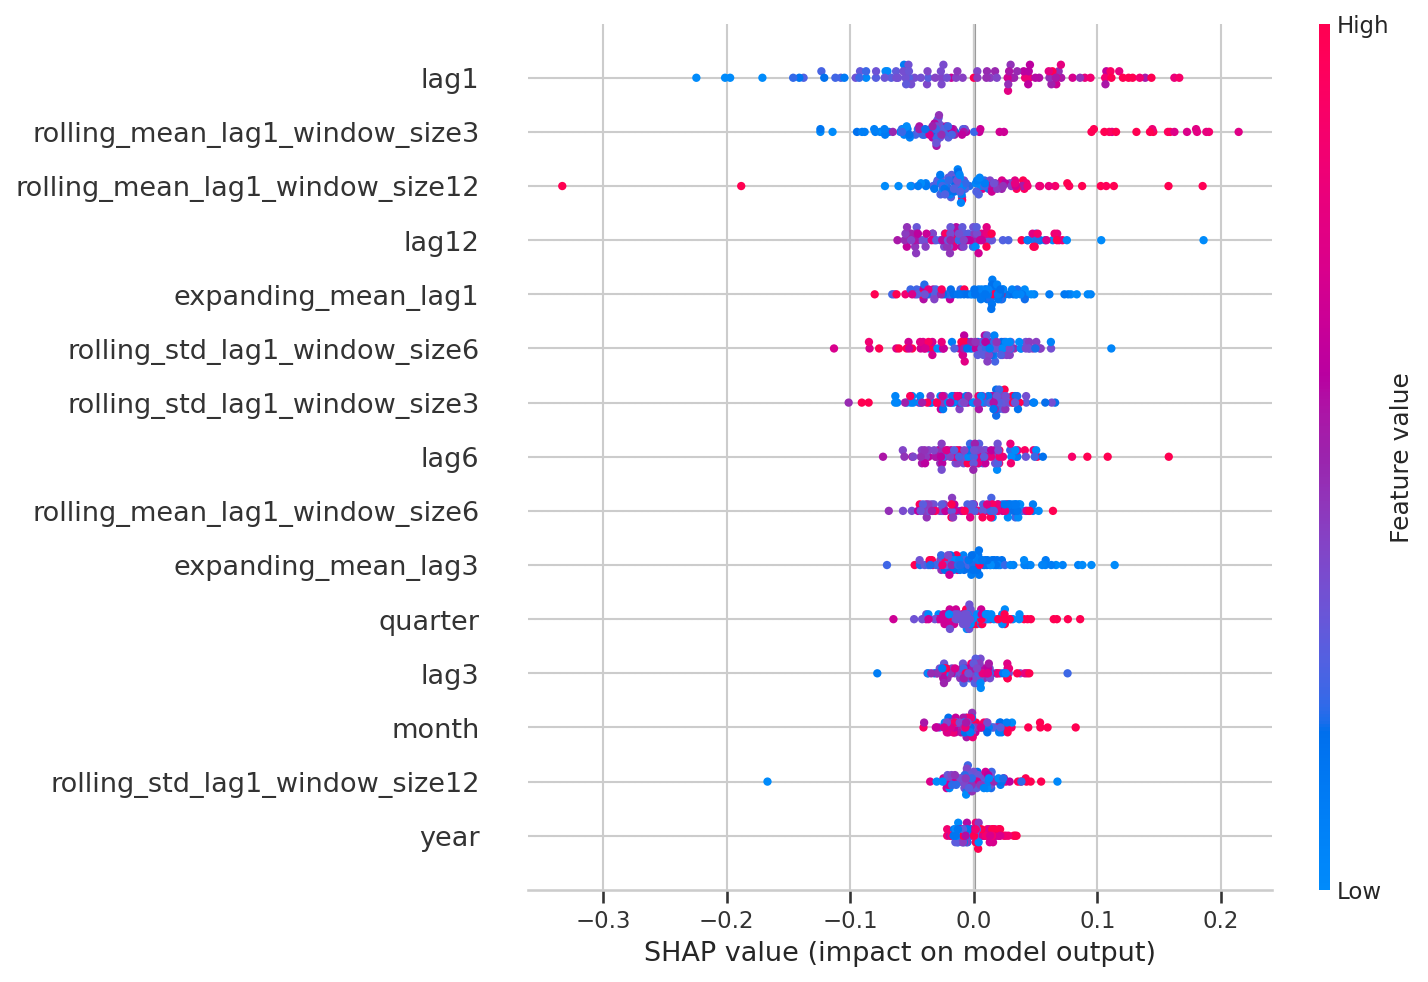

In [103]:
# pre-proc the df_train
df_train_prep, _ = fcst.preprocess(df_train, return_X_y=True)

# Get the catboost model
model = fcst.models_['CatBoostRegressor']

# Getting the SHAP values from the LGBM model
explainer = shap.TreeExplainer(model)
shap_values = explainer(df_train_prep)
shap.plots.beeswarm(shap_values, max_display=25)


In [104]:
print('Max date:', df['ds'].max())
print('Min date:', df['ds'].min())

Max date: 2025-05-01 00:00:00
Min date: 2015-01-01 00:00:00


In [105]:
levels = [90, 95]
predictions = fcst.predict(12, level=levels, X_df=df_test)

In [106]:
predictions.head()

,unique_id,ds,CatBoostRegressor,CatBoostRegressor-lo-95,CatBoostRegressor-lo-90,CatBoostRegressor-hi-90,CatBoostRegressor-hi-95
0,1,2024-06-01,0.596524,0.208773,0.260111,0.932937,0.984275
1,1,2024-07-01,0.476588,-0.761116,-0.658632,1.611808,1.714291
2,1,2024-08-01,0.402456,-0.411049,-0.364740,1.169652,1.215961
3,1,2024-09-01,0.453075,-0.394807,-0.390032,1.296183,1.300957
4,1,2024-10-01,0.382743,-0.555249,-0.449491,1.214977,1.320735


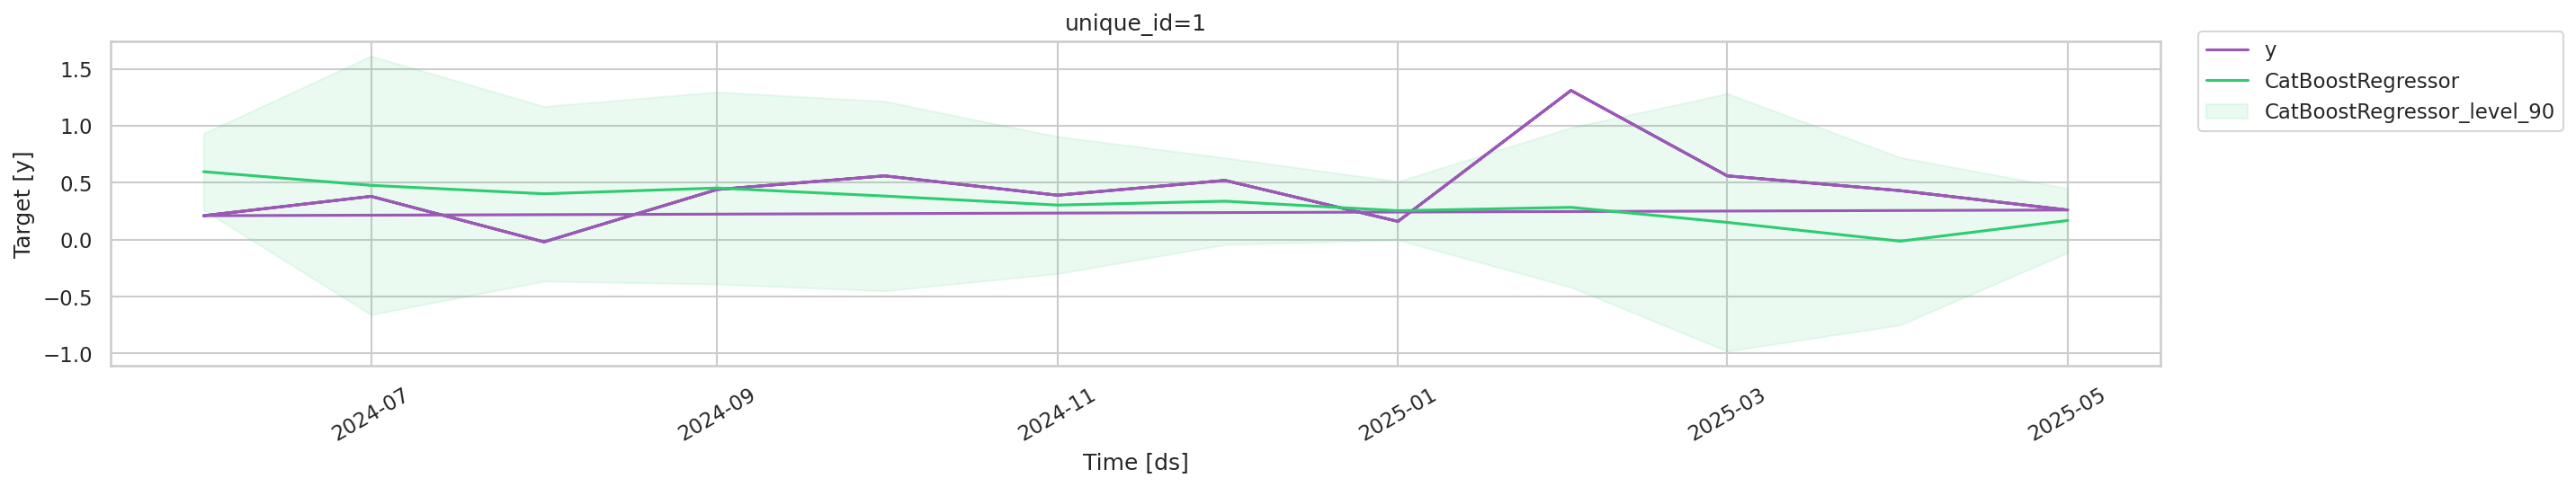

In [107]:
# Merge the test dateset with all predictions
test_df_final = df_test.merge(predictions, how='left', on=['unique_id', 'ds'])

# Plot the model forecasting
fig = plot_series(
    test_df_final, 
    test_df_final, 
    plot_random=False, 
    level=[90],
    max_insample_length=2000,
    models=['CatBoostRegressor'],
)
fig



In [108]:
metrics = [
    mape,
    mae,
    coverage
]

results = evaluate(test_df_final, metrics, level=[90])
results

,unique_id,metric,CatBoostRegressor
0,1,mape,2.301825
1,1,mae,0.285807
2,1,coverage_level90,0.833333


In [143]:
test_df_final

,unique_id,ds,y,CatBoostRegressor,CatBoostRegressor-lo-95,CatBoostRegressor-lo-90,CatBoostRegressor-hi-90,CatBoostRegressor-hi-95
0,1,2024-06-01,0.21,0.596524,0.208773,0.260111,0.932937,0.984275
1,1,2024-07-01,0.38,0.476588,-0.761116,-0.658632,1.611808,1.714291
2,1,2024-08-01,-0.02,0.402456,-0.411049,-0.364740,1.169652,1.215961
3,1,2024-09-01,0.44,0.453075,-0.394807,-0.390032,1.296183,1.300957
4,1,2024-10-01,0.56,0.382743,-0.555249,-0.449491,1.214977,1.320735
5,1,2024-11-01,0.39,0.303336,-0.375456,-0.298359,0.905030,0.982127
6,1,2024-12-01,0.52,0.337516,-0.051929,-0.043687,0.718720,0.726962
7,1,2025-01-01,0.16,0.253682,-0.008166,-0.003104,0.510468,0.515530
8,1,2025-02-01,1.31,0.283465,-0.439602,-0.417406,0.984336,1.006532
9,1,2025-03-01,0.56,0.151313,-1.101036,-0.979392,1.282019,1.403663


In [135]:
future_predictions = fcst.predict(h=24)  # Prever os próximos 12 passos

In [136]:
future_predictions

,unique_id,ds,CatBoostRegressor
0,1,2024-06-01,0.596524
1,1,2024-07-01,0.476588
2,1,2024-08-01,0.402456
3,1,2024-09-01,0.453075
4,1,2024-10-01,0.382743
5,1,2024-11-01,0.303336
6,1,2024-12-01,0.337516
7,1,2025-01-01,0.253682
8,1,2025-02-01,0.283465
9,1,2025-03-01,0.151313


In [138]:
# 1. Obter a última data do conjunto de teste (como você já fez)
last_date = df_test['ds'].max()

# 2. Filtrar as previsões para mostrar apenas datas > last_date
future_only_predictions = future_predictions[future_predictions['ds'] > last_date]

# 3. Mostrar o resultado
future_only_predictions

,unique_id,ds,CatBoostRegressor
12,1,2025-06-01,0.185104
13,1,2025-07-01,0.187847
14,1,2025-08-01,0.113282
15,1,2025-09-01,0.085791
16,1,2025-10-01,0.231211
17,1,2025-11-01,0.321946
18,1,2025-12-01,0.520156
19,1,2026-01-01,0.420776
20,1,2026-02-01,0.499618
21,1,2026-03-01,0.374696


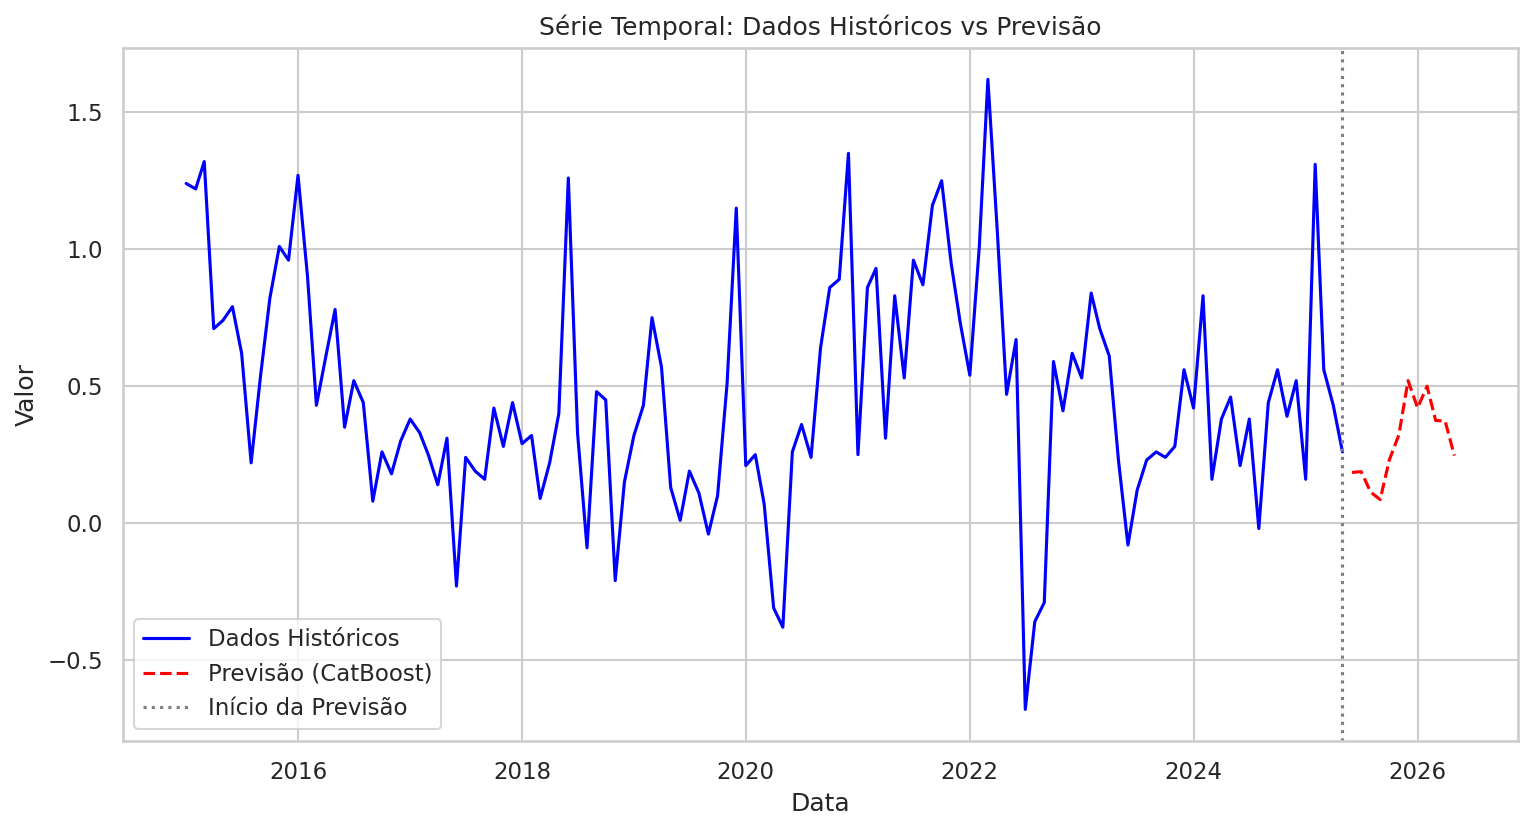

In [139]:
import matplotlib.pyplot as plt

# Filtrar a série original (df) e as previsões
df_original = df[['ds', 'y']]  # Assumindo que 'y' é a coluna alvo
df_predictions = future_only_predictions[['ds', 'CatBoostRegressor']].rename(columns={'CatBoostRegressor': 'y_pred'})

# Plotar a série original
plt.figure(figsize=(12, 6))
plt.plot(df_original['ds'], df_original['y'], label='Dados Históricos', color='blue')

# Plotar as previsões futuras
plt.plot(df_predictions['ds'], df_predictions['y_pred'], label='Previsão (CatBoost)', color='red', linestyle='--')

# Adicionar linha vertical para marcar o início das previsões
last_historical_date = df['ds'].max()
plt.axvline(x=last_historical_date, color='gray', linestyle=':', label='Início da Previsão')

# Configurações do gráfico
plt.title('Série Temporal: Dados Históricos vs Previsão')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

In [141]:
import pandas as pd

# Renomear a coluna de previsões para compatibilidade
future_only_predictions = future_only_predictions.rename(columns={'CatBoostRegressor': 'y'})

# Concatenar dados históricos e previsões
full_series = pd.concat([
    df[['ds', 'y']],
    future_only_predictions[['ds', 'y']]
], ignore_index=True)

In [142]:
full_series

,ds,y
0,2015-01-01,1.240000
1,2015-02-01,1.220000
2,2015-03-01,1.320000
3,2015-04-01,0.710000
4,2015-05-01,0.740000
...,...,...
132,2026-01-01,0.420776
133,2026-02-01,0.499618
134,2026-03-01,0.374696
135,2026-04-01,0.372674
